<a href="https://colab.research.google.com/github/AnaICouto/AnaICouto/blob/main/C%C3%B3pia_de_Sound_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


Notes:
Not using "soundata" package because it was crashing with google colab env
Downloaded the dataset through the link


Used this to unzip dataset and to get started: https://colab.research.google.com/github/jsalbert/sound_classification_ml_production/blob/main/notebooks/UrbanSound8k_data_exploration.ipynb#scrollTo=_5j_Mm1p0Mpt

In [ ]:
# Unzip dataset
#!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
#!tar -xzf urban8k.tgz
#!rm urban8k.tgz

In [ ]:
import tarfile

# Replace 'your_file.tar' with the actual name of your tar file
tar_file_path = 'drive/MyDrive/UrbanSound8K.tar'

# Replace 'extracted_folder' with the desired name for the extracted folder
extracted_folder = 'drive/MyDrive/UrbanSound8K'

# Open the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Extract all contents to the specified folder
    tar.extractall(path=extracted_folder)

In [ ]:
#!tar -xzf Drive/MyDrive/urban8k.tgz
#!rm urban8k.tgz
!cat UrbanSound8K/UrbanSound8K/UrbanSound8K_README.txt

Install Packages

Audio processing: librosa, mutagen
Plots: Plotly, matplotlib

In [ ]:
#!pip install pandas
#!pip install librosa
#!pip install plotly
#!pip install matplotlib
!pip install mutagen
#!pip install pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
#Import required modules
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import seaborn as sns

In [ ]:
# Create df with metadata
df = pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')

In [ ]:
#inspect df
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


### https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook

Column Names:\
**slice_file_name**: The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where: [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken [classID] = a numeric identifier of the sound class (see description of classID below for further details) [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence\

**fsID**: The Freesound ID of the recording from which this excerpt (slice) is taken\

**start**: The start time of the slice in the original Freesound recording\

**end**: The end time of slice in the original Freesound recording

**salience**: A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

**fold**: The fold number (1-10) to which this file has been allocated.

**classID**: A numeric identifier of the sound class: 0 = air_conditioner 1 = car_horn 2 = children_playing 3 = dog_bark 4 = drilling 5 = engine_idling 6 = gun_shot 7 = jackhammer 8 = siren 9 = street_music

**class**: The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music.



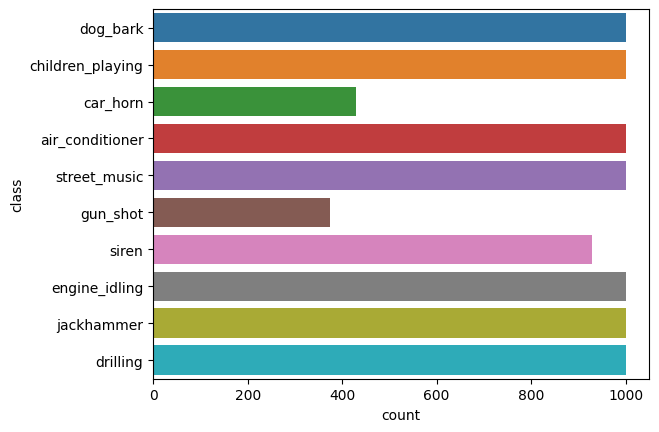

In [ ]:
df.groupby('class').fsID.count()

# from https://www.kaggle.com/code/hissain/urbansound8k-beginners
sns.countplot(df, y="class")
plt.show()

We can observe all the classes except **car_horn**, **gun_shot** and **siren** have 1000 samples.

> We could explore options to include class weights in the loss function or oversampling if we see that the under-represented classes are not being classified as well as the rest




In [ ]:
# https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook

# Using Librosa to analyse random sound sample - SPECTOGRAM¶

dat1, sampling_rate1 = librosa.load('UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('UrbanSound8K/UrbanSound8K/audio/fold5/100263-2-0-117.wav')


In [ ]:
#Inspect what is dat1 and sampling_rate1

print(dat1)
print(sampling_rate1)

[-0.00347107 -0.00501926 -0.00465449 ... -0.00248442 -0.00154777
 -0.00035547]
22050


### According to the librosa library, when loading the file we can choose the sampling rate and this is something the Professor talked about when presenting the project.

### Maybe we should use a sampling rate similar accross all sound clips. Check which is the lower possible sampling rate

#### The desired sampling rate can be passed to "librosa.load" as a parameter; default is None

https://librosa.org/doc/latest/generated/librosa.load.html#librosa.load

In [ ]:
#Trying to implement a defined sampling rate = 200
dat3, sampling_rate_200 = librosa.load('UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav', sr=200)
print(dat3, sampling_rate_200)

[ 1.13929280e-04 -5.22702430e-05 -3.10074174e-05 -5.32484919e-05
  7.51382104e-05 -7.32873159e-05  1.91688188e-04 -8.68833449e-05
 -1.81240874e-04 -5.17905282e-05 -5.34761784e-06  1.02980877e-04
 -1.76618982e-04  1.39857730e-04 -1.04177088e-04 -1.00706573e-04
  1.60455020e-04 -1.89590355e-05 -1.85254714e-04  5.20893809e-06
  3.30988143e-04 -3.93913244e-04 -1.09670276e-04  3.66554770e-04
 -1.24128841e-04 -1.19848402e-04  2.12735089e-04  1.53796173e-05
 -1.73085893e-04  6.57891433e-05  6.31319417e-05  4.62586540e-05
 -2.13150721e-04  2.28308956e-04 -1.28654443e-04  2.51922320e-05
 -6.30366185e-06  1.00873534e-04 -7.29575549e-05 -7.55828878e-05
  1.45595186e-04 -1.85368379e-04  1.66981219e-04 -1.02727499e-04
  1.52770270e-04 -2.44607916e-04  1.53422981e-04 -4.65018238e-05
  6.25358080e-05 -9.66699736e-06 -8.38404958e-07  4.39479263e-05
 -1.63558521e-04  1.76957052e-04 -1.57328628e-04  1.55384885e-04
 -1.26259081e-04  9.65867512e-05 -1.55262125e-04  6.81058445e-05
  1.21777688e-04 -1.68346

## Get audio metadata to understand how the sounds were collected



In [ ]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
#https://colab.research.google.com/github/jsalbert/sound_classification_ml_production/blob/main/notebooks/UrbanSound8k_data_exploration.ipynb#scrollTo=IUiDNGlGdEAH
# These functions will allow to collect data from the recording framework which can be used as fetures if considered relevant

def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata


def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]

    return dataset_df

In [ ]:
    filepaths = []
    for i, row in df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    df['filepath'] = filepaths

In [ ]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,UrbanSound8K/UrbanSound8K/audio/fold5/100032-3...
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...


In [ ]:
# https://mutagen.readthedocs.io/en/latest/api/wave.html
#Checking what kind of data mutagen will extract, to further understand the dataframe
get_audio_metadata_mutagen('UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav')


{'length': 0.31755102040816324,
 'bitrate': 1411200,
 'channels': 2,
 'sample_rate': 44100,
 'bits_per_sample': 16}

**Length** - audio length (seconds)\
**Bitrate** - bit rate (bits / second)\
**Channels** - number of channels used to record the audio (1: mono; 2: stereo)\
**Sample_rate** - sample rate (Hz)\
**Bits_per_sample** - audio sample rate (Hz)\
\
*Some considerations*: This information is important to make decisions regarding the dataset preprocessing. For example: sound clips can have different durations or sampling rates and we need to decide whether this should be a festure.



In [ ]:
# include above mentioned data in the df

df = compute_audio_statistics(df)

Columns slice_file: name, fsID, start and end were not considered relevant for the analysis and were removed

In [ ]:
# Dropping non-relevant columns
df = df.drop(columns=['slice_file_name', 'fsID', 'start', 'end'])

In [ ]:
df.describe()

,salience,fold,classID,length,bitrate,channels,sample_rate,bits_per_sample
count,8732.000000,8732.000000,8732.000000,8732.000000,8.732000e+03,8732.000000,8732.000000,8732.000000
mean,1.347000,5.385937,4.592877,3.603644,1.800775e+06,1.915369,48456.979272,18.780119
std,0.476043,2.846820,2.894544,0.980913,9.765852e+05,0.278348,15300.080707,4.227168
min,1.000000,1.000000,0.000000,0.000816,4.409600e+04,1.000000,8000.000000,4.000000
25%,1.000000,3.000000,2.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
50%,1.000000,5.000000,4.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
75%,2.000000,8.000000,7.000000,4.000000,2.116800e+06,2.000000,48000.000000,24.000000
max,2.000000,10.000000,9.000000,4.000000,1.228800e+07,2.000000,192000.000000,32.000000


We can observe in the following tables that the data has been recorded and digitalized in different ways.

It has been mostly recorded using 2 channels in almost all the samples (stereo).
The sample rates go from 8kHz to 192kHz (mostly 44kHz, 48Khz)
The length of the audios goes from 0.0008s to 4s (mostly 4s)
The bits per sample used go from 4 to 32 (mostly 24 bits)
The data will need to be standardized before to be fed to a machine learning model.

In [ ]:
from IPython.display import display

In [ ]:
#Displaying the whole table

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.groupby('class').describe())

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                    fold                                                \
                   count      mean       std  min  25%  50%  75%   max   
class                                                                    
air_conditioner   1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
car_horn           429.0  5.121212  2.614525  1.0  3.0  5.0  7.0  10.0   
children_playing  1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
dog_bark          1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
drilling          1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
engine_idling     1000.0  5.399000  2.809215  1.0  3.0  5.0  8.0  10.0   
gun_shot           374.0  5.446524  2.739068  1.0  3.0  6.0  7.0  10.0   
jackhammer        1000.0  5.062000  2.896644  1.0  3.0  5.0  8.0  10.0   
siren              929.0  5.204521  2.802235  1.0  3.0  5.0  8.0  10.0   
street_music      1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   

                 classID                                     length            \
                   count mean  std  min  25%  50%  75%  max   count      mean   
class                                                                           
air_conditioner   1000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1000.0  3.994928   
car_horn           429.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   429.0  2.456123   
children_playing  1000.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  1000.0  3.933895   
dog_bark          1000.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0  1000.0  3.148281   
drilling          1000.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0  1000.0  3.542295   
engine_idling     1000.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0  1000.0  3.935952   
gun_shot           374.0  6.0  0.0  6.0  6.0  6.0  6.0  6.0   374.0  1.647699   
jackhammer        1000.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0  1000.0  3.609071   
siren              929.0  8.0  0.0  8.0  8.0  8.0  8.0  8.0   929.0  3.910314   
street_music      1000.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0  1000.0  4.000000   

                                                                         \
                       std       min       25%       50%       75%  max   
class                                                                     
air_conditioner   0.093128  2.040000  4.000000  4.000000  4.000000  4.0   
car_horn          1.618848  0.050000  0.738292  3.490000  4.000000  4.0   
children_playing  0.424658  0.008073  4.000000  4.000000  4.000000  4.0   
dog_bark          1.331572  0.119819  2.040000  4.000000  4.000000  4.0   
drilling          1.013475  0.007937  4.000000  4.000000  4.000000  4.0   
engine_idling     0.370909  0.766553  4.000000  4.000000  4.000000  4.0   
gun_shot          0.902516  0.166281  1.009195  1.472698  2.185255  4.0   
jackhammer        0.891129  0.000816  4.000000  4.000000  4.000000  4.0   
siren             0.502674  0.260000  4.000000  4.000000  4.000000  4.0   
street_music      0.000000  4.000000  4.000000  4.000000  4.000000  4.0   

                 bitrate                                     

Data Visualization\
As the data consists of Audio files we will use the Librosa library to load, plot and perform audio processing.




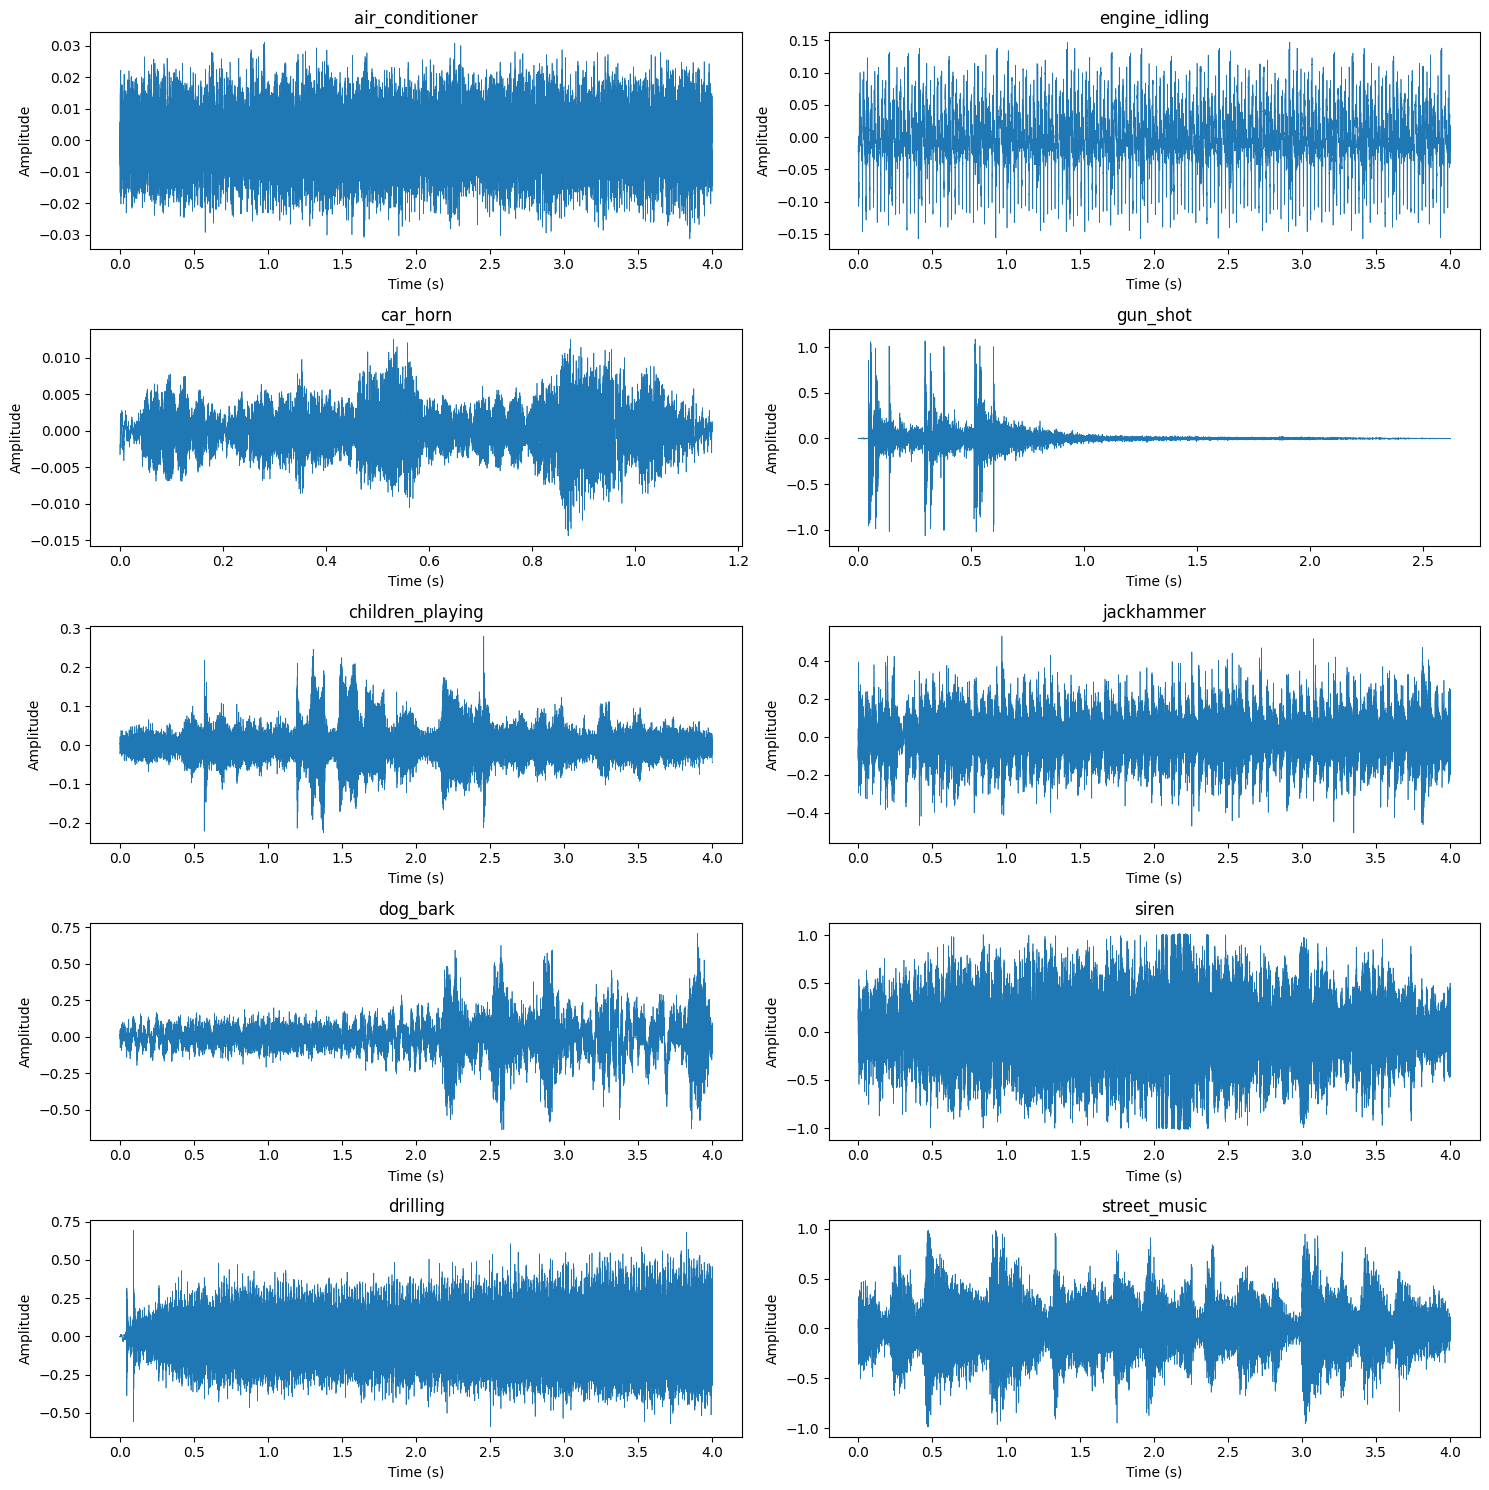

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Randomly select one sample of each class
random_samples = df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
index = 0

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        duration = librosa.get_duration(y=audio_file, sr=sample_rate)
        time = librosa.samples_to_time(range(len(audio_file)), sr=sample_rate)

        axs[row][col].plot(time, audio_file, linewidth=0.5)
        axs[row][col].set_title('{}'.format(labels[index]))
        axs[row][col].set_xlabel('Time (s)')
        axs[row][col].set_ylabel('Amplitude')

        index += 1

fig.tight_layout()
plt.show()


STFT (Short-Term Fourier Transform), Mel-Spectograms and MFCC (Mel-Frequency Cepstral Coefficients) are all popular ways to process audio signals and generate features as input for machine learning algorithms such as Convolutional Neural Networks.

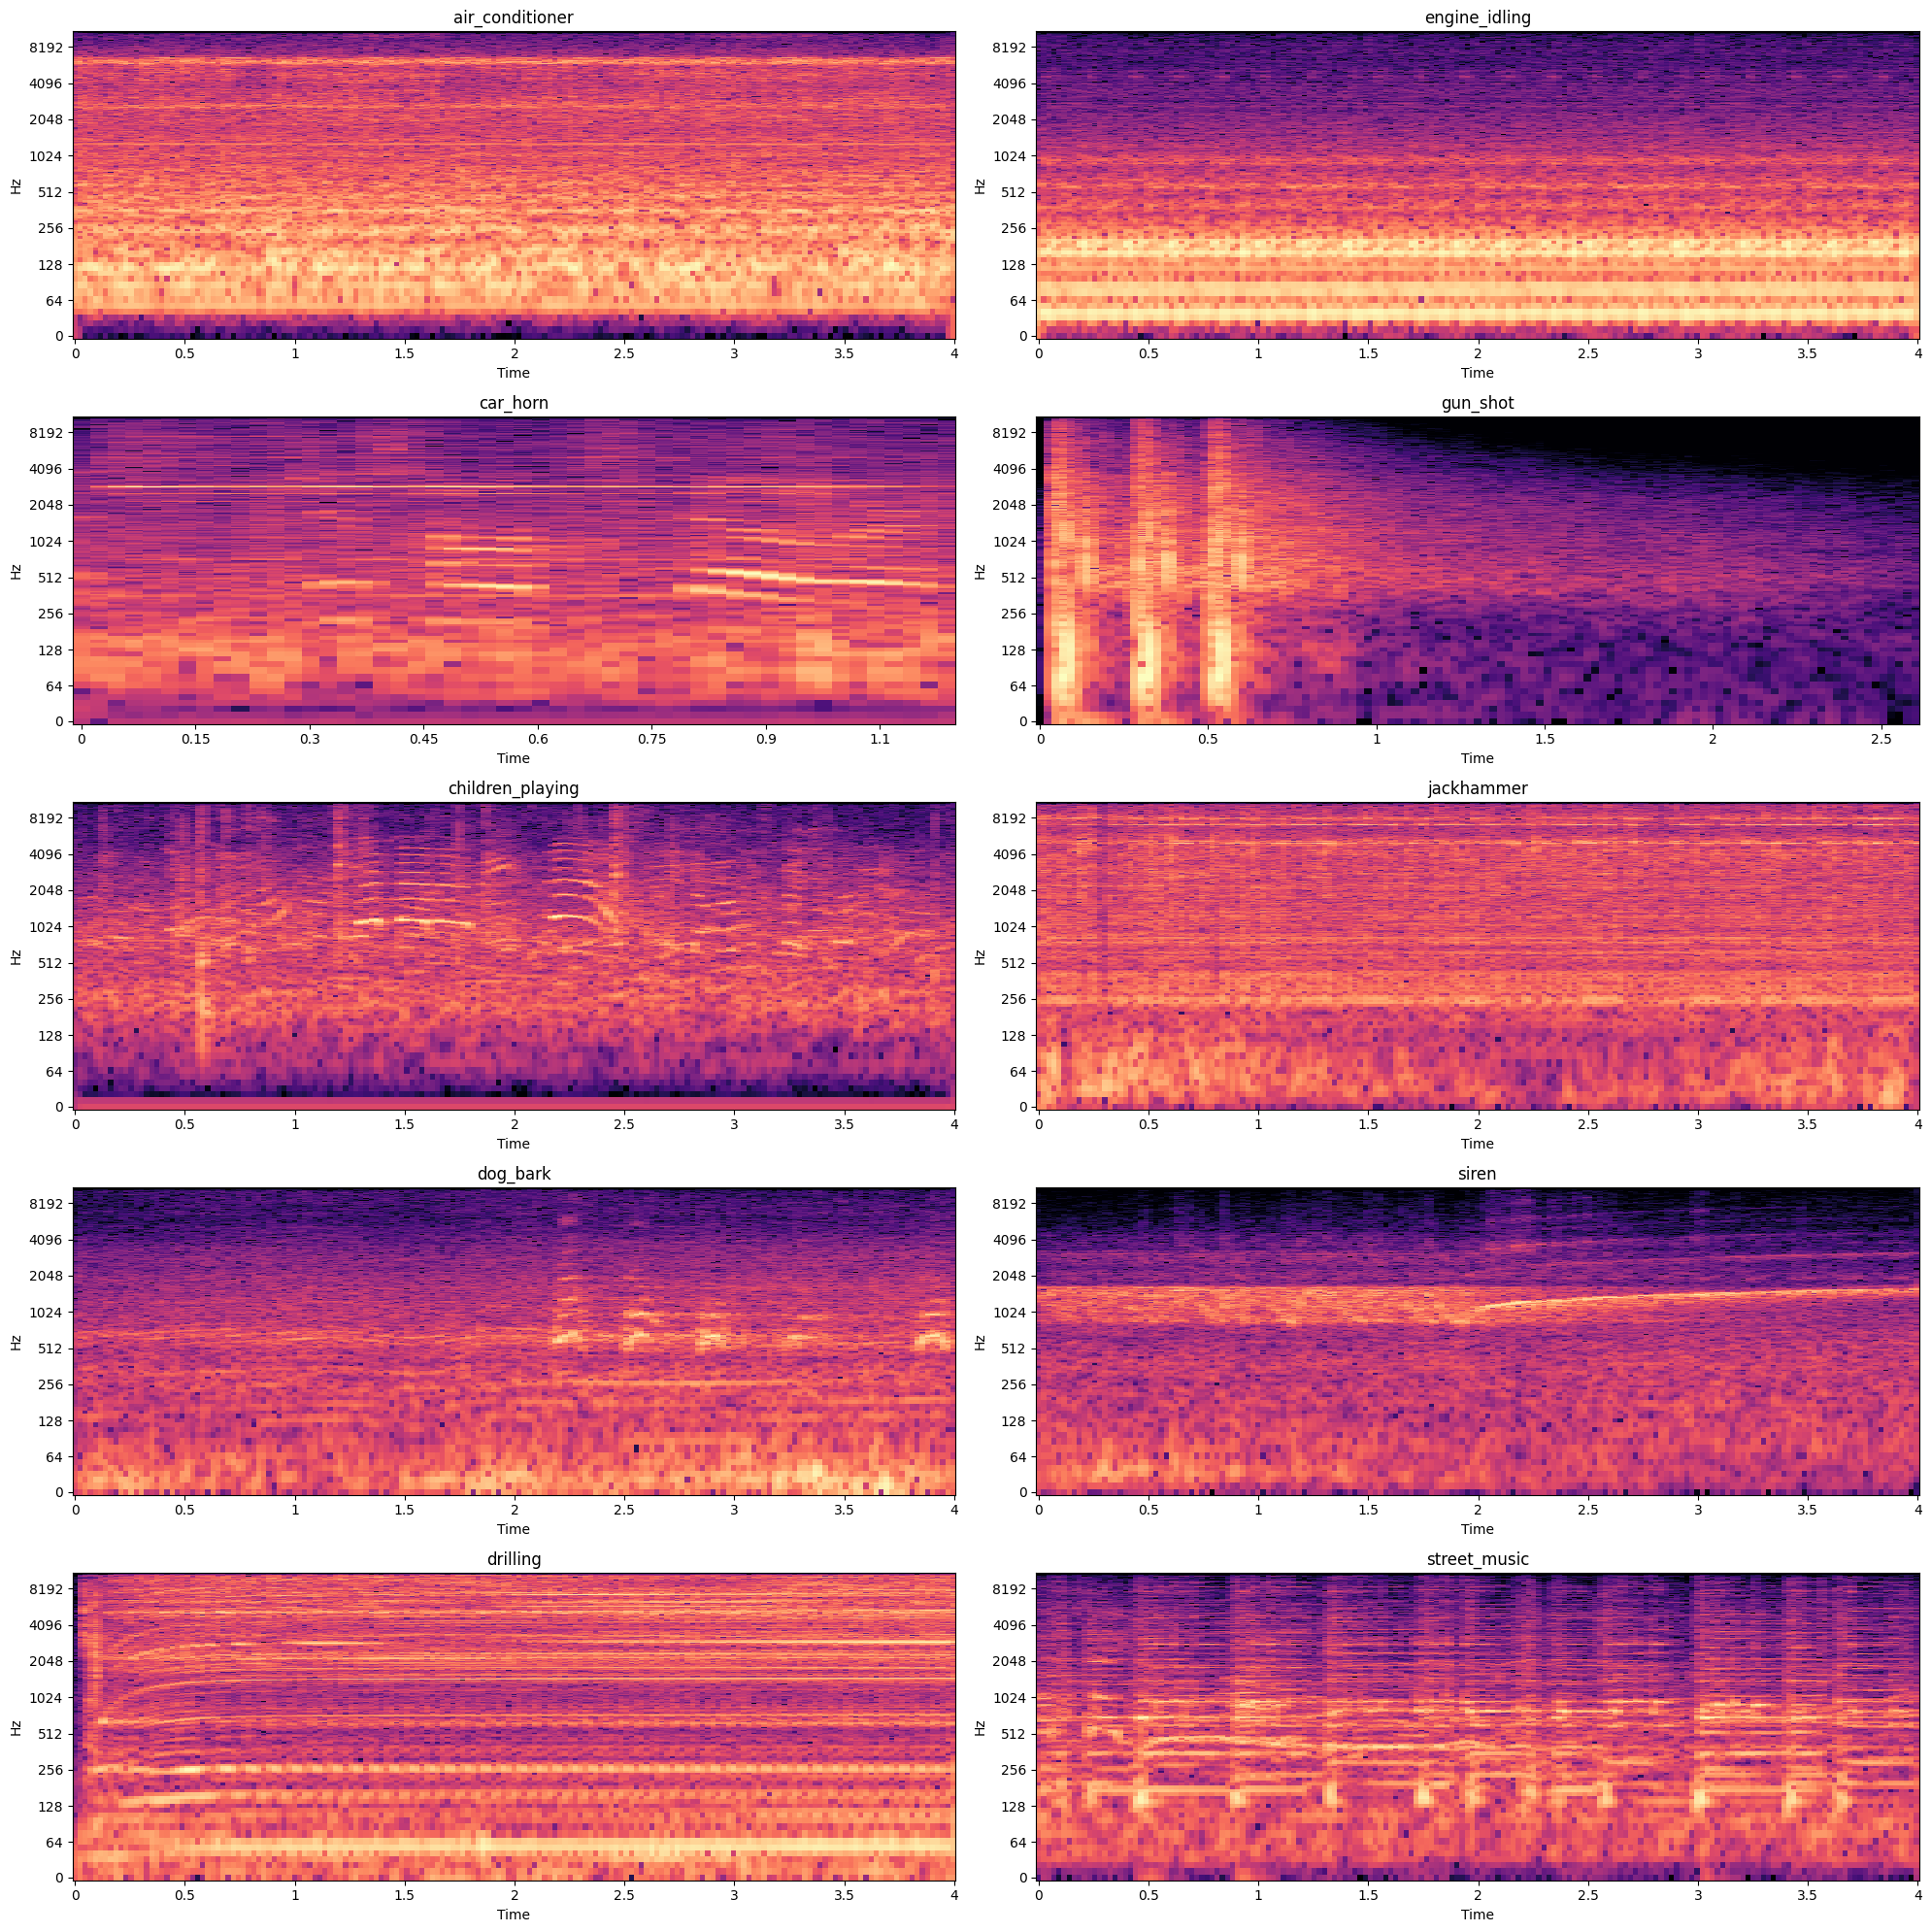

In [ ]:

import numpy as np

# Visualize the STFT
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis='log',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()

Next we will visualize the Mel-Spectogram which is a representation of the different frequencies magnitudes at different timesteps. The frequency magnitude is transformed to be on the Mel Scale, that takes into account how humans perceive and process audio signals.


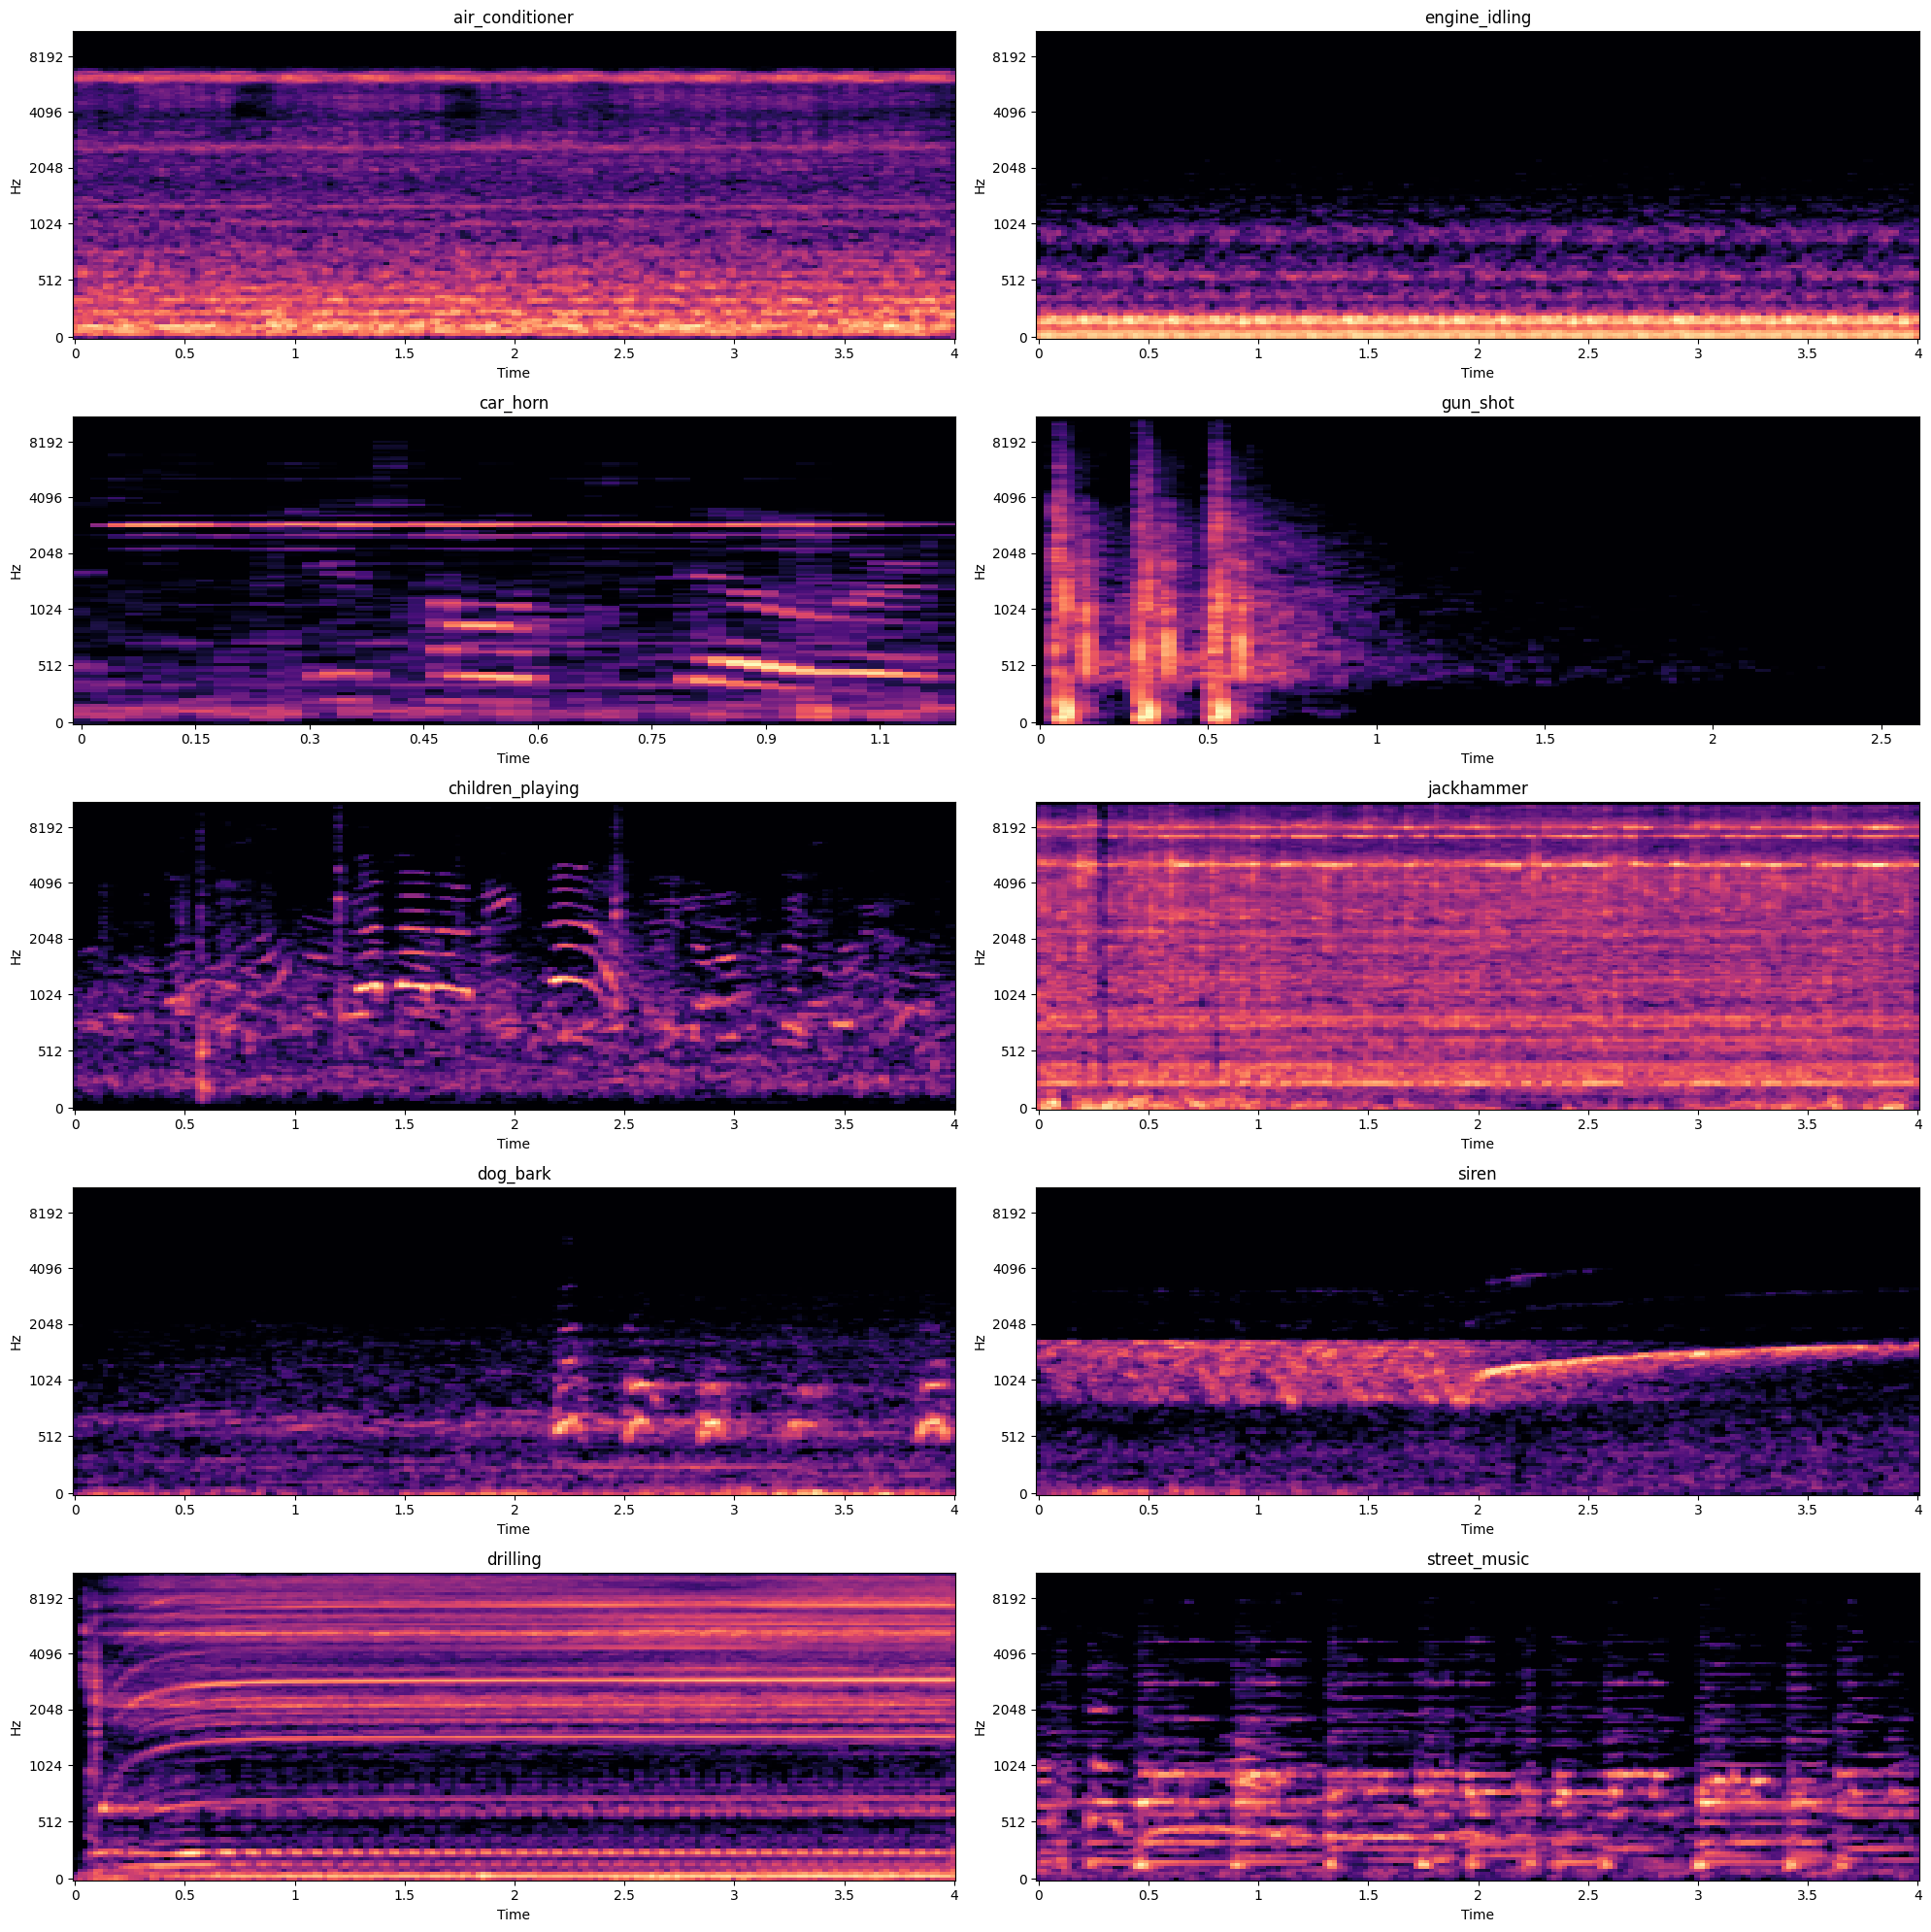

In [ ]:
# Visualize the Mel-Spectrograms
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0
n_s = 4

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mel_spec = librosa.feature.melspectrogram(y=audio_file, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(S_db,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis='mel',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()

## From here:
 https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

 #### After looking into the functions, it doesn't seem like I can handle this.

In [ ]:
"""import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio"""

'import math, random\nimport torch\nimport torchaudio\nfrom torchaudio import transforms\nfrom IPython.display import Audio'

Convert to two channels\
Some of the sound files are mono (ie. 1 audio channel) while most of them are stereo (ie. 2 audio channels). Since our model expects all items to have the same dimensions, we will convert the mono files to stereo, by duplicating the first channel to the second.

In [ ]:
 """# ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
    def rechannel(aud, new_channel):
      sig, sr = aud

      if (sig.shape[0] == new_channel):
        # Nothing to do
        return aud

      if (new_channel == 1):
        # Convert from stereo to mono by selecting only the first channel
        resig = sig[:1, :]
      else:
        # Convert from mono to stereo by duplicating the first channel
        resig = torch.cat([sig, sig])

      return ((resig, sr))"""

'# ----------------------------\n # Convert the given audio to the desired number of channels\n # ----------------------------\n @staticmethod\n   def rechannel(aud, new_channel):\n     sig, sr = aud\n\n     if (sig.shape[0] == new_channel):\n       # Nothing to do\n       return aud\n\n     if (new_channel == 1):\n       # Convert from stereo to mono by selecting only the first channel\n       resig = sig[:1, :]\n     else:\n       # Convert from mono to stereo by duplicating the first channel\n       resig = torch.cat([sig, sig])\n\n     return ((resig, sr))'

Standardize sampling rate\
Some of the sound files are sampled at a sample rate of 48000Hz, while most are sampled at a rate of 44100Hz. This means that 1 second of audio will have an array size of 48000 for some sound files, while it will have a smaller array size of 44100 for the others. Once again, we must standardize and convert all audio to the same sampling rate so that all arrays have the same dimensions.

In [ ]:
 """ # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))"""

' # ----------------------------\n # Since Resample applies to a single channel, we resample one channel at a time\n # ----------------------------\n @staticmethod\n def resample(aud, newsr):\n   sig, sr = aud\n\n   if (sr == newsr):\n     # Nothing to do\n     return aud\n\n   num_channels = sig.shape[0]\n   # Resample first channel\n   resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])\n   if (num_channels > 1):\n     # Resample the second channel and merge both channels\n     retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])\n     resig = torch.cat([resig, retwo])\n\n   return ((resig, newsr))'

Resize to the same length\
We then resize all the audio samples to have the same length by either extending its duration by padding it with silence, or by truncating it. We add that method to our AudioUtil class.

In [ ]:

 """ # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)

    return (sig, sr)"""

" # ----------------------------\n # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds\n # ----------------------------\n @staticmethod\n def pad_trunc(aud, max_ms):\n   sig, sr = aud\n   num_rows, sig_len = sig.shape\n   max_len = sr//1000 * max_ms\n\n   if (sig_len > max_len):\n     # Truncate the signal to the given length\n     sig = sig[:,:max_len]\n\n   elif (sig_len < max_len):\n     # Length of padding to add at the beginning and end of the signal\n     pad_begin_len = random.randint(0, max_len - sig_len)\n     pad_end_len = max_len - sig_len - pad_begin_len\n\n     # Pad with 0s\n     pad_begin = torch.zeros((num_rows, pad_begin_len))\n     pad_end = torch.zeros((num_rows, pad_end_len))\n\n     sig = torch.cat((pad_begin, sig, pad_end), 1)\n\n   return (sig, sr)"

## From feature_extraction_example.ypnb provided by the Professor

In [ ]:
#Import required modules
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import seaborn as sns

In [ ]:
# Find all wav file in dir

_wav_dir_="UrbanSound8K/UrbanSound8K/audio/fold8/"
files = librosa.util.find_files(_wav_dir_)

In [ ]:
import librosa
import numpy as np

from datetime import datetime
from pathlib  import Path

audio_dir  = 'UrbanSound8K/UrbanSound8K/audio/'
#audio_dir  = '/home/storage/dataset_urbansound8k/audio/'
output_dir = '/home/storage/dataset_urbansound8k/'

nfolds = 10

target_duration      = 4
target_sample_rate   = 44_100
target_total_samples = target_duration * target_sample_rate

def main() -> None:
    '''
    X_folds = [fold1_Xs : np.ndarray( shape=(n_files_on_fold, target_total_samples) ), ..., fold10(..)]
    y_folds = [fold1_ys : np.ndarray( shape=(n_files_on_fold,) ),                      ..., fold10(..)]
    '''
    X_folds = []
    y_folds = []

    for fold in range(1, 1 + nfolds):
        X, y = uniformize_fold(fold)
        X_folds.append(X)
        y_folds.append(y)

    # np.savez(file, *args, **kwds)
    # np.save(f'{output_file}/uniform_dataset_X.npy', X, allow_pickle=False)
    # np.save(f'{output_file}/uniform_dataset_y.npy', y, allow_pickle=False)

    return X_folds, y_folds

def uniformize_fold(fold: int) -> tuple[np.ndarray, np.ndarray]:
    '''
    Make all sounds the same sample rate and same duration
    '''
    assert fold in range(1, 1 + nfolds)

    fold_dir = f'{audio_dir}/fold{ fold }/'
    files : list[str] = librosa.util.find_files(fold_dir)

    l = len(files)
    X = np.zeros(shape=(l, target_total_samples), dtype=np.float32)
    y = np.zeros(shape=(l,),                      dtype=np.uint8)

    for i, f in enumerate(files):
        ############ Get y[i]
        # File names are standardized
        # [fsID]-[classID]-[occurrenceID]-[sliceID].wav
        # we split on '-' and get the class id
        # '118558-5-1-2.wav' → ['118558', '5', '1', '2.wav']
        p = Path(f)
        y[i] = int(p.name.split('-')[1])

        ############ Get X[i]
        sig, rate = librosa.load(f,
                                 sr=target_sample_rate, # does RESAMPLING, default is 22050
                                 mono=True,             # default is to average down to mono
                                 duration=None,         # would we ever want to load part of it?
        )

        if len(sig) < target_total_samples:
            # repeat values till shape is filled
            sig = np.resize(sig, (target_total_samples,))

        elif len(sig) > target_total_samples:
            print(f'file={f} has {len(sig)} samples which corresponds to {len(sig) / target_sample_rate}s')

            assert (len(sig) - target_total_samples) / target_sample_rate < 0.1, 'Will not truncate more than 0.1s of sound'
            print(f'Truncating to {target_total_samples} samples')


            sig = sig[:target_total_samples]

        X[i] = sig

    return X, y

if __name__ == '__main__':
    s = datetime.now()
    X_folds, y_folds = main()
    print(f'Elapsed: {datetime.now() - s}')


file=/content/UrbanSound8K/UrbanSound8K/audio/fold5/19007-4-0-0.wav has 176750 samples which corresponds to 4.007936507936508s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-13.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-14.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-15.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-18.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-23.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2

In [ ]:
import librosa
import numpy as np

from datetime import datetime
from pathlib  import Path

audio_dir  = 'UrbanSound8K/UrbanSound8K/audio/'
#audio_dir  = '/home/storage/dataset_urbansound8k/audio/'
output_dir = '/home/storage/dataset_urbansound8k/'

nfolds = 10

target_duration      = 4
target_sample_rate   = 44_100
target_total_samples = target_duration * target_sample_rate

# MFCC parameters
n_mfcc = 40
hop_length = round(0.0125 * target_sample_rate)
win_length = round(0.023 * target_sample_rate)
n_fft      = 2**14
mfcc_time_size = 4 * target_sample_rate // hop_length + 1

def main() -> None:
    '''
    X_folds = [fold1_Xs : np.ndarray( shape=(n_files_on_fold, target_total_samples) ), ..., fold10(..)]
    y_folds = [fold1_ys : np.ndarray( shape=(n_files_on_fold,) ),                      ..., fold10(..)]
    '''
    X_folds      = []
    X_feat_folds = []
    y_folds      = []

    for fold in range(1, 1 + nfolds):
        print(f'Starting fold: {fold}')
        X, X_feat, y = uniformize_fold(fold)
        X_folds.append(X)
        X_feat_folds.append(X_feat)
        y_folds.append(y)

    # np.savez(file, *args, **kwds)
    # np.save(f'{output_file}/uniform_dataset_X.npy', X, allow_pickle=False)
    # np.save(f'{output_file}/uniform_dataset_y.npy', y, allow_pickle=False)

    return X_folds, X_feat_folds, y_folds

def uniformize_fold(fold: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Make all sounds the same sample rate and same duration
    '''
    assert fold in range(1, 1 + nfolds)

    fold_dir = f'{audio_dir}/fold{ fold }/'
    files : list[str] = librosa.util.find_files(fold_dir)

    l = len(files)
    X      = np.zeros(shape=(l, target_total_samples),   dtype=np.float32)
    X_feat = np.zeros(shape=(l, n_mfcc, mfcc_time_size), dtype=np.float32)
    y      = np.zeros(shape=(l,),                        dtype=np.uint8)

    for i, f in enumerate(files):
        ############ Get y[i]
        # File names are standardized
        # [fsID]-[classID]-[occurrenceID]-[sliceID].wav
        # we split on '-' and get the class id
        # '118558-5-1-2.wav' → ['118558', '5', '1', '2.wav']
        p = Path(f)
        y[i] = int(p.name.split('-')[1])

        ############ Get X[i]
        sig, rate = librosa.load(f,
                                 sr=target_sample_rate, # does RESAMPLING, default is 22050
                                 mono=True,             # default is to average down to mono
                                 duration=None,         # would we ever want to load part of it?
        )

        if len(sig) < target_total_samples:
            # repeat values till shape is filled
            sig = np.resize(sig, (target_total_samples,))

        elif len(sig) > target_total_samples:
            print(f'file={f} has {len(sig)} samples which corresponds to {len(sig) / target_sample_rate}s')

            assert (len(sig) - target_total_samples) / target_sample_rate < 0.1, 'Will not truncate more than 0.1s of sound'
            print(f'Truncating to {target_total_samples} samples')


            sig = sig[:target_total_samples]

        X[i] = sig

        # print(f'Extracting features {i}th:')
        X_feat[i] = librosa.feature.mfcc(y=sig,
                                         sr=target_sample_rate,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         win_length=win_length,
                                         n_mfcc=n_mfcc,
        )

    return X, X_feat, y

if __name__ == '__main__':
    s = datetime.now()
    X_folds, X_folds, y_folds = main()
    print(f'Elapsed: {datetime.now() - s}')


Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
file=/content/UrbanSound8K/UrbanSound8K/audio/fold5/19007-4-0-0.wav has 176750 samples which corresponds to 4.007936507936508s
Truncating to 176400 samples
Starting fold: 6
Starting fold: 7
Starting fold: 8
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-13.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-14.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-15.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-18.wav has 178017 samples which corresponds to 4.036666666666667s
Truncating to 176400 samples
file=/content/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-23.wav has 178017 

In [ ]:
len(y_folds)

10

In [ ]:
len(X_feat_folds[9])

NameError: ignored

# AQUI!

In [ ]:
import librosa
import numpy as np
import os

from datetime import datetime
from pathlib  import Path

audio_dir  = 'drive/MyDrive/UrbanSound8K/UrbanSound8K/audio'
#audio_dir  = '/home/storage/dataset_urbansound8k/audio'
#output_dir = '/home/storage/dataset_urbansound8k/preprocessed'
output_dir = 'drive/MyDrive/UrbanSound8K/UrbanSound8K/preprocessed'
os.makedirs(output_dir, exist_ok=True)

nfolds = 10

target_duration      = 4
target_sample_rate   = 44_100
target_total_samples = target_duration * target_sample_rate

# MFCC parameters
n_mfcc = 40
hop_length = round(0.0125 * target_sample_rate)
win_length = round(0.023  * target_sample_rate)
n_fft      = 2**14
mfcc_time_size = 4 * target_sample_rate // hop_length + 1

def main() -> None:
    '''
    X_folds = [fold1_Xs : np.ndarray( shape=(n_files_on_fold, target_total_samples) ), ..., fold10(..)]
    y_folds = [fold1_ys : np.ndarray( shape=(n_files_on_fold,) ),                      ..., fold10(..)]
    '''
    uniform_duration_sample_ds : dict[str, np.ndarray] = {}
    mfcc_features_ds           : dict[str, np.ndarray] = {}

    for fold in range(1, 1 + nfolds):
        print(f'Starting fold: {fold}')

        X, X_feat, y = uniformize_fold(fold)

        uniform_duration_sample_ds[f'X_fold{fold}'] = X
        uniform_duration_sample_ds[f'y_fold{fold}'] = y

        mfcc_features_ds[f'X_fold{fold}'] = X_feat
        mfcc_features_ds[f'y_fold{fold}'] = y

    # Save the datasets
    np.savez(f'{output_dir}/dataset_uniform_duration_sample.npz', **uniform_duration_sample_ds)
    np.savez(f'{output_dir}/dataset_mfcc_features.npz',           **mfcc_features_ds)

    return

def uniformize_fold(fold: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Make all sounds the same sample rate and same duration
    '''
    assert fold in range(1, 1 + nfolds)

    fold_dir = f'{audio_dir}/fold{ fold }/'
    files : list[str] = librosa.util.find_files(fold_dir)

    l = len(files)
    X      = np.zeros(shape=(l, target_total_samples),   dtype=np.float32)
    X_feat = np.zeros(shape=(l, n_mfcc, mfcc_time_size), dtype=np.float32)
    y      = np.zeros(shape=(l,),                        dtype=np.uint8)

    for i, f in enumerate(files):
        ############ Get y[i]
        # File names are standardized
        # [fsID]-[classID]-[occurrenceID]-[sliceID].wav
        # we split on '-' and get the class id
        # '118558-5-1-2.wav' → ['118558', '5', '1', '2.wav']
        p = Path(f)
        y[i] = int(p.name.split('-')[1])

        ############ Get X[i]
        sig, _ = librosa.load(f,
                              sr=target_sample_rate, # does RESAMPLING, default is 22050
                              mono=True,             # default is to average down to mono
                              duration=None,         # would we ever want to load part of it?
        )

        if len(sig) < target_total_samples:
            # repeat values till shape is filled
            sig = np.resize(sig, (target_total_samples,))

        elif len(sig) > target_total_samples:
            assert (len(sig) - target_total_samples) / target_sample_rate < 0.1, 'Will not truncate more than 0.1s of sound'

            print(
                f'>> file={f}'                                                   '\n'
                f'>> Samples:   { len(sig) } ({len(sig) / target_sample_rate}s)' '\n'
                f'>> Truncated: {target_total_samples} samples'
            )

            sig = sig[:target_total_samples]

        X[i] = sig

        X_feat[i] = librosa.feature.mfcc(y=sig,
                                         sr=target_sample_rate,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         win_length=win_length,
                                         n_mfcc=n_mfcc,
        )

    return X, X_feat, y

if __name__ == '__main__':
    s = datetime.now()
    main()
    print(f'Elapsed: {datetime.now() - s}')


Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
>> file=/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold5/19007-4-0-0.wav
>> Samples:   176750 (4.007936507936508s)
>> Truncated: 176400 samples
Starting fold: 6
Starting fold: 7
Starting fold: 8
>> file=/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-13.wav
>> Samples:   178017 (4.036666666666667s)
>> Truncated: 176400 samples
>> file=/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-14.wav
>> Samples:   178017 (4.036666666666667s)
>> Truncated: 176400 samples
>> file=/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-15.wav
>> Samples:   178017 (4.036666666666667s)
>> Truncated: 176400 samples
>> file=/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-18.wav
>> Samples:   178017 (4.036666666666667s)
>> Truncated: 176400 samples
>> file=/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold8/36429-2-0-2

In [7]:
'''
Load preprocessed dataset

Usage:
X_folds, y_folds      = load_dataset('dataset_uniform_duration_sample')
X_feat_folds, y_folds = load_dataset('dataset_mfcc_features')
'''
import numpy as np

# load_dir = '/home/storage/dataset_urbansound8k/preprocessed'
load_dir = 'drive/MyDrive/UrbanSound8K/UrbanSound8K/preprocessed'
nfolds   = 10

def load_dataset(ds_name : str) -> tuple[list[np.ndarray],
                                      list[np.ndarray]]:
    '''
    Open a npz saved dataset.
    Examples:
    - uniform_duration_sample : X_folds,      y_folds
    - mfcc_features           : X_feat_folds, y_folds
    '''
    path = f'{load_dir}/{ds_name}.npz'

    X_folds : list[np.ndarray] = []
    y_folds : list[np.ndarray] = []

    with np.load(path, allow_pickle=False) as f:
        # Arrays are stored as:
        # 'X_fold1', 'X_fold2', ..
        # 'y_fold1', 'y_fold2', ..

        for fold in range(1, 1 + nfolds):
            X = f[f'X_fold{fold}']
            y = f[f'y_fold{fold}']

            X_folds.append(X)
            y_folds.append(y)


    return X_folds, y_folds


In [8]:

import numpy as np

In [18]:
# Load extracted features
#X_folds, y_folds      = load_dataset('dataset_uniform_duration_sample')
X_feat_folds, y_folds = load_dataset('dataset_mfcc_features')


In [19]:
X_feat_folds[0]

array([[[-4.63114807e+02, -4.59116516e+02, -4.57935608e+02, ...,
         -3.73826172e+02, -3.48723145e+02, -2.22139511e+02],
        [ 6.40553474e+00,  1.19068775e+01,  1.36498241e+01, ...,
          1.13063095e+02,  1.37978104e+02,  1.48628723e+02],
        [ 6.24039459e+00,  1.12966080e+01,  1.32494965e+01, ...,
          6.80363007e+01,  7.35527649e+01,  3.10699177e+01],
        ...,
        [ 1.69163585e+00, -1.88172722e+00, -1.18501663e+00, ...,
         -1.35005226e+01,  6.93821073e-01, -8.34117770e-01],
        [ 1.85451460e+00, -1.54264975e+00, -1.28383946e+00, ...,
         -1.17721024e+01,  8.82750511e-01, -1.76682878e+00],
        [ 1.98301339e+00, -1.20623875e+00, -1.36647534e+00, ...,
         -4.00551987e+00,  2.95866489e+00,  3.04722953e+00]],

       [[-4.52009186e+02, -4.55008026e+02, -4.52380280e+02, ...,
         -4.53190704e+02, -4.48462860e+02, -4.48516937e+02],
        [ 1.86001930e+01,  1.41102381e+01,  1.73808479e+01, ...,
          1.70611305e+01,  2.32617397e

In [20]:
for fold in range (nfolds):
  print (fold, X_feat_folds[fold].shape, len(X_feat_folds[fold]))

0 (873, 40, 321) 873
1 (888, 40, 321) 888
2 (925, 40, 321) 925
3 (990, 40, 321) 990
4 (936, 40, 321) 936
5 (823, 40, 321) 823
6 (838, 40, 321) 838
7 (806, 40, 321) 806
8 (816, 40, 321) 816
9 (837, 40, 321) 837


In [21]:
print(X_feat_folds[0][0])

[[-463.1148     -459.11652    -457.9356     ... -373.82617
  -348.72314    -222.13951   ]
 [   6.4055347    11.9068775    13.649824   ...  113.063095
   137.9781      148.62872   ]
 [   6.2403946    11.296608     13.249496   ...   68.0363
    73.552765     31.069918  ]
 ...
 [   1.6916358    -1.8817272    -1.1850166  ...  -13.500523
     0.6938211    -0.83411777]
 [   1.8545146    -1.5426497    -1.2838395  ...  -11.772102
     0.8827505    -1.7668288 ]
 [   1.9830134    -1.2062387    -1.3664753  ...   -4.00552
     2.958665      3.0472295 ]]


In [28]:

# Normalize data
for X in X_feat_folds:
    max = np.max(X, axis=0)
    min = np.min(X, axis=0)

    X = (X - min) / (max - min)


In [33]:
print(X_feat_folds[0][0])

[[0.4108256  0.38732857 0.39372334 ... 0.48401088 0.5171908  0.6671408 ]
 [0.27534014 0.21421298 0.22571874 ... 0.4763988  0.5296174  0.5972753 ]
 [0.63575995 0.75840604 0.78314626 ... 0.996555   1.         0.84292316]
 ...
 [0.52123874 0.47836474 0.5617085  ... 0.36562398 0.614635   0.51789474]
 [0.5549911  0.37699872 0.3877383  ... 0.19875057 0.44604364 0.45565543]
 [0.56453586 0.44723505 0.41932335 ... 0.39623192 0.5658118  0.5356103 ]]


In [54]:
# import useful libraries
import tensorflow as tf
import torch
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [55]:
# clear previous sessions
tf.keras.backend.clear_session()

# FF-NN

#### Basically following the Hands-On3 from ML-II classes

In [36]:
'''
for i in range(nfolds):
  # Prepare the training validation and test sets
  X_val = X_feat_folds[i]
  y_val = y_folds[i]
  X_test = X_feat_folds[nfolds-1]
  y_test = y_folds[nfolds-1]
  X_train = np.concatenate([X_feat_folds[j] for j in range(nfolds-1) if j != i])
  y_train = np.concatenate([y_folds[j] for j in range(nfolds-1) if j != i])
'''

# Prepare validation and train datasets
# strating with just 2 folds to check if I can do this
'''
X_val = X_feat_folds[0]
X_train = np.concatenate([X_feat_folds[1], X_feat_folds[2]])
y_val = y_folds[0]
y_train = np.concatenate ([y_folds[1], y_folds[2]])
'''


X_test  = X_feat_folds[9]
y_test  = y_folds[9]
X_val   = X_feat_folds[8]
y_val   = y_folds[8]
X_train = np.concatenate([X_feat_folds[j] for j in range(8)])
y_train = np.concatenate([y_folds[j] for j in range(8)])

In [37]:
'''
# classes one-hot encoding
# doesn't work
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
'''

"\n# classes one-hot encoding\n# doesn't work\ny_train = to_categorical(y_train, num_classes=10)\ny_val = to_categorical(y_val, num_classes=10)\n"

In [38]:
X_val.shape, y_val.shape

((816, 40, 321), (816,))

In [39]:
X_train.shape, y_train.shape

((7079, 40, 321), (7079,))

In [40]:
X_train[2].shape

(40, 321)

In [ ]:
# normalize data from Hands-on 3 - ML-II classes
# Not going to use this
'''

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_train = ds_train.batch(128)
ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(128)
'''

In [ ]:
#xtrainval, xtest, ytrainval, ytest = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
#xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)

In [41]:
# import useful libraries
import tensorflow as tf
import matplotlib.pyplot as plt

# 1 - NN based on the hands-on 3 from classes


In [45]:
# define the neural network architecture
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(40,
321)),
tf.keras.layers.Dense(64,
activation='relu'),
tf.keras.layers.Dense(10,
activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12840)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                821824    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 822474 (3.14 MB)
Trainable params: 822474 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# compile model and define training options
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)

In [47]:
from datetime import datetime

s = datetime.now()

# train the model
history = model.fit(
X_train,y_train,
epochs=20,
batch_size=128,
validation_data=(X_val, y_val),
)

print(f'Elapsed: {datetime.now()-s}')

Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 302.8868 - sparse_categorical_accuracy: 0.2560 - val_loss: 3.8450 - val_sparse_categorical_accuracy: 0.1311
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 3.2160 - sparse_categorical_accuracy: 0.2298 - val_loss: 2.2460 - val_sparse_categorical_accuracy: 0.1703
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 2.4627 - sparse_categorical_accuracy: 0.2379 - val_loss: 2.3093 - val_sparse_categorical_accuracy: 0.1900
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 2.2619 - sparse_categorical_accuracy: 0.2571 - val_loss: 2.2544 - val_sparse_categorical_accuracy: 0.1973
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 2.1600 - sparse_categorical_accuracy: 0.2790 - val_loss: 2.2478 - val_sparse_categorical_accuracy: 0.1949
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 2.1586 - sparse_categorical_ac

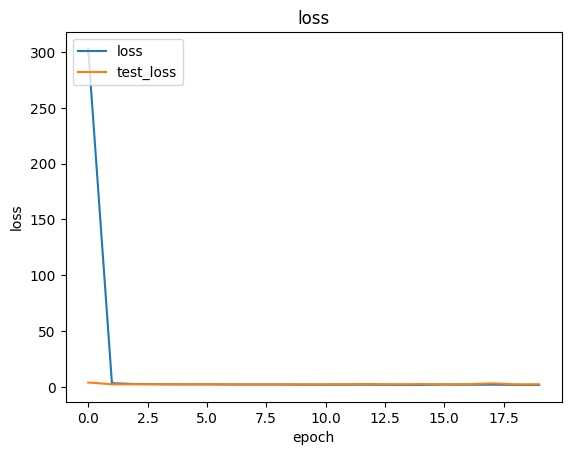

222/222 [==============================] - 1s 6ms/step - loss: 1.7151 - sparse_categorical_accuracy: 0.3599
Test accuracy: 0.359937846660614


In [48]:

# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','test_loss'], loc='upper left')
plt.show()

# Evaluate the model
scores = model.evaluate(X_train, y_train)

print("Test accuracy:",scores[1])

# NN bsaed on: https://www.kaggle.com/code/sachinsarkar/urban-sound-classification-usnig-librosa-and-ann

In [49]:

# define the neural network architecture based on https://www.kaggle.com/code/sachinsarkar/urban-sound-classification-usnig-librosa-and-ann
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(40, 321)),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dense(750, activation='relu'),
tf.keras.layers.Dense(500, activation='relu'),
tf.keras.layers.Dense(250, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(50, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12840)             0         
                                                                 
 dense_4 (Dense)             (None, 1000)              12841000  
                                                                 
 dense_5 (Dense)             (None, 750)               750750    
                                                                 
 dense_6 (Dense)             (None, 500)               375500    
                                                                 
 dense_7 (Dense)             (None, 250)               125250    
                                                                 
 dense_8 (Dense)             (None, 100)               25100     
                                                                 
 dense_9 (Dense)             (None, 50)               

In [ ]:
# compile model and define training options
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)

In [52]:
# train the model
history = model.fit(
X_train,y_train,
epochs=20,
batch_size=128,
validation_data=(X_val, y_val),
)

Epoch 1/20
56/56 [==============================] - 25s 403ms/step - loss: 312.4000 - sparse_categorical_accuracy: 0.1376 - val_loss: 4.5825 - val_sparse_categorical_accuracy: 0.1275
Epoch 2/20
56/56 [==============================] - 24s 430ms/step - loss: 2.6041 - sparse_categorical_accuracy: 0.1160 - val_loss: 2.2668 - val_sparse_categorical_accuracy: 0.1005
Epoch 3/20
56/56 [==============================] - 21s 376ms/step - loss: 2.2684 - sparse_categorical_accuracy: 0.1167 - val_loss: 2.2549 - val_sparse_categorical_accuracy: 0.1005
Epoch 4/20
56/56 [==============================] - 25s 437ms/step - loss: 2.2638 - sparse_categorical_accuracy: 0.1147 - val_loss: 2.2500 - val_sparse_categorical_accuracy: 0.1005
Epoch 5/20
56/56 [==============================] - 24s 429ms/step - loss: 2.2624 - sparse_categorical_accuracy: 0.1161 - val_loss: 2.2477 - val_sparse_categorical_accuracy: 0.1005
Epoch 6/20
56/56 [==============================] - 31s 567ms/step - loss: 2.2622 - sparse_ca

KeyboardInterrupt: ignored

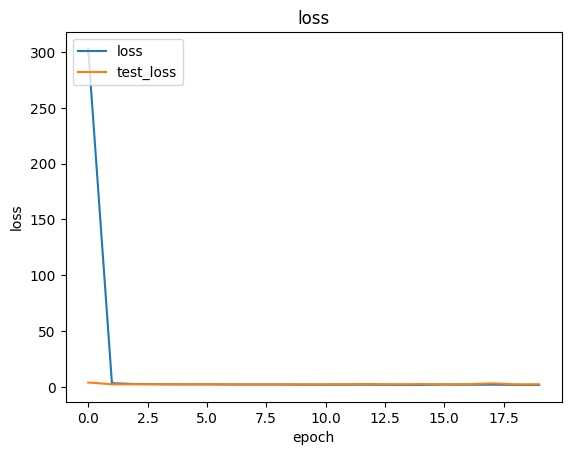

222/222 [==============================] - 9s 41ms/step - loss: 2.2616 - sparse_categorical_accuracy: 0.1156
Test accuracy: 0.11555304378271103


In [53]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','test_loss'], loc='upper left')
plt.show()

# Evaluate the model
scores = model.evaluate(X_train, y_train)

print("Test accuracy:",scores[1])

In [54]:

# define the neural network architecture based on https://www.kaggle.com/code/sachinsarkar/urban-sound-classification-usnig-librosa-and-ann
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(40, 321)),
tf.keras.layers.Dense(1000, activation='relu'),
tf.keras.layers.Dense(750, activation='relu'),
tf.keras.layers.Dense(500, activation='relu'),
tf.keras.layers.Dense(250, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(50, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12840)             0         
                                                                 
 dense_11 (Dense)            (None, 1000)              12841000  
                                                                 
 dense_12 (Dense)            (None, 750)               750750    
                                                                 
 dense_13 (Dense)            (None, 500)               375500    
                                                                 
 dense_14 (Dense)            (None, 250)               125250    
                                                                 
 dense_15 (Dense)            (None, 100)               25100     
                                                                 
 dense_16 (Dense)            (None, 50)               

## Decrease learning rate

In [55]:
# compile model and define training options
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)

In [56]:
# train the model
history = model.fit(
X_train,y_train,
epochs=20,
batch_size=128,
validation_data=(X_val, y_val),
)

Epoch 1/20
56/56 [==============================] - 23s 394ms/step - loss: 15.9253 - sparse_categorical_accuracy: 0.2293 - val_loss: 2.1821 - val_sparse_categorical_accuracy: 0.4571
Epoch 2/20
56/56 [==============================] - 23s 411ms/step - loss: 1.6093 - sparse_categorical_accuracy: 0.4494 - val_loss: 2.1417 - val_sparse_categorical_accuracy: 0.5233
Epoch 3/20
56/56 [==============================] - 21s 378ms/step - loss: 1.2959 - sparse_categorical_accuracy: 0.5584 - val_loss: 2.0211 - val_sparse_categorical_accuracy: 0.4620
Epoch 4/20
56/56 [==============================] - 21s 374ms/step - loss: 1.1209 - sparse_categorical_accuracy: 0.6292 - val_loss: 2.1730 - val_sparse_categorical_accuracy: 0.5429
Epoch 5/20
56/56 [==============================] - 21s 377ms/step - loss: 0.9692 - sparse_categorical_accuracy: 0.6766 - val_loss: 2.1777 - val_sparse_categorical_accuracy: 0.5564
Epoch 6/20
56/56 [==============================] - 23s 411ms/step - loss: 0.8071 - sparse_cat

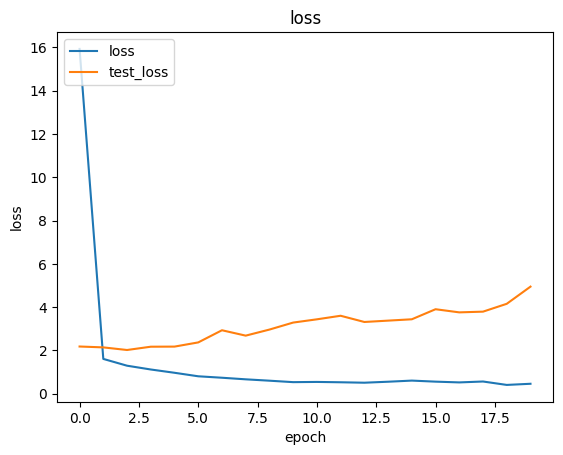

222/222 [==============================] - 8s 35ms/step - loss: 0.4693 - sparse_categorical_accuracy: 0.8270
Test accuracy: 0.8269529342651367


In [57]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','test_loss'], loc='upper left')
plt.show()

# Evaluate the model
scores = model.evaluate(X_train, y_train)

print("Test accuracy:",scores[1])

## Add drop-out

In [65]:
# define the neural network architecture based on https://www.kaggle.com/code/sachinsarkar/urban-sound-classification-usnig-librosa-and-ann
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(40, 321)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add a dropout layer with a dropout rate of 0.5
    tf.keras.layers.Dense(750, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(500, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(250, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 12840)             0         
                                                                 
 dense_25 (Dense)            (None, 1000)              12841000  
                                                                 
 dropout_6 (Dropout)         (None, 1000)              0         
                                                                 
 dense_26 (Dense)            (None, 750)               750750    
                                                                 
 dense_27 (Dense)            (None, 500)               375500    
                                                                 
 dense_28 (Dense)            (None, 250)               125250    
                                                                 
 dense_29 (Dense)            (None, 100)              

In [66]:
# compile model and define training options
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)

In [67]:
from keras.callbacks import EarlyStopping

# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

# train the model
history = model.fit(
X_train,y_train,
callbacks=[earlystop],
epochs=20,
batch_size=128,
validation_data=(X_val, y_val),
)

Epoch 1/20
56/56 [==============================] - 24s 393ms/step - loss: 12.6181 - sparse_categorical_accuracy: 0.1728 - val_loss: 1.9710 - val_sparse_categorical_accuracy: 0.4203
Epoch 2/20
56/56 [==============================] - 24s 430ms/step - loss: 2.0431 - sparse_categorical_accuracy: 0.2760 - val_loss: 1.5509 - val_sparse_categorical_accuracy: 0.4914
Epoch 3/20
56/56 [==============================] - 22s 386ms/step - loss: 1.7802 - sparse_categorical_accuracy: 0.3681 - val_loss: 1.3634 - val_sparse_categorical_accuracy: 0.5441
Epoch 4/20
56/56 [==============================] - 23s 415ms/step - loss: 1.6275 - sparse_categorical_accuracy: 0.4255 - val_loss: 1.3973 - val_sparse_categorical_accuracy: 0.5282
Epoch 5/20
56/56 [==============================] - 23s 400ms/step - loss: 1.5306 - sparse_categorical_accuracy: 0.4652 - val_loss: 1.5578 - val_sparse_categorical_accuracy: 0.5074
Epoch 6/20
56/56 [==============================] - 22s 388ms/step - loss: 1.4364 - sparse_cat

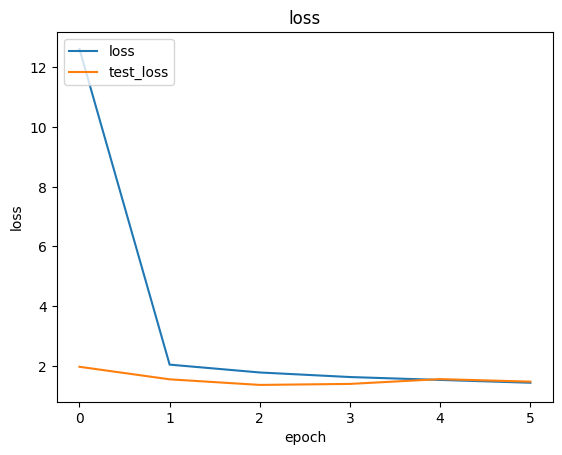

222/222 [==============================] - 7s 33ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.5622
Test accuracy: 0.5622262954711914


In [68]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','test_loss'], loc='upper left')
plt.show()

# Evaluate the model
scores = model.evaluate(X_train, y_train)

print("Test accuracy:",scores[1])


https://www.kaggle.com/code/sachinsarkar/urban-sound-classification-usnig-librosa-and-ann **MFCC**\
https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification **MEL Spectogram**\
https://colab.research.google.com/github/jsalbert/sound_classification_ml_production/blob/main/notebooks/UrbanSound8k_data_exploration.ipynb?pli=1#scrollTo=YWDyO8Ik09AS **bom p/ outras coisas, não tem feat extraction**\
https://www.kaggle.com/code/sreevaatsavbavana/sound-classifiaction-using-ml-and-deep-learning#Extracting-features-from-Audio-data **extracts all librosa features**\
https://www.kaggle.com/code/susant4learning/urbansound8k-dataprep-model **MFCC**\
https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook#Feature-Extraction-and-Database-Building **Mel Spectrogram**\
**Librosa library** https://librosa.org/doc/latest/feature.html\
https://www.kaggle.com/code/furkannakdagg/urban-sound-classification#Hyperparameter-Optimization **cnn and hyperparameter tuning**\
https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV **DataSet Source**\
Paper com **literature review**: Nogueira, A.F.R.; Oliveira, H.S.; Machado, J.J.M.; Tavares, J.M.R.S. Sound Classification and Processing of Urban Environments: A Systematic Literature Review. Sensors 2022, 22, 8608. https://doi.org/10.3390/s22228608

